In [13]:
import torch
import torch.autograd
from torch.autograd import Variable
from torch import autograd
import numpy as np
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
import time
import sys
sys.path.append(os.path.join(os.getcwd(), '../Final_Code/', 'utils'))
#from compute_tau import compute_tau_star
import matplotlib.patches as mpatches
import scipy.sparse.linalg
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import seaborn as sns
sns.set()
sns.set_style("whitegrid",  {"grid.linewidth": 0.6})
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
figsize = (8, 6)
figsize2 = (16, 6)
marker_list = ['o', 'v', 's', 'P', '*', 'X', 'D']
cmap = plt.get_cmap("tab10")
cmap2 = plt.get_cmap("tab20")
contour_cmap = plt.cm.get_cmap('Greys_r')
contour_points = 100000
alpha = .6
fig_dir = os.path.join(os.getcwd(), 'polynomial_figs')
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
ss= 250
ms=15
ms2=20
ls=20
fs=30
fs2=24
lsp=0.1
htp=.1
ms3=.5
pad = 20
offset=850
auto_limits=True
run_test=False
x_lims_def = [-20, 20]
y_lims_def = [-20, 20]
cmap3 = cm.inferno
xlims_3d =[-25,25]
ylims_3d =[-25,25]
density = 1.25
mew=2
slw = 2.5
verbose=True
show=True
save=True
lw=4
frameon=False
a = 0.3
b = 0.3

#from wolframclient.evaluation import WolframLanguageSession
#session=WolframLanguageSession()
#from wolframclient.language import wl
#import numpy.linalg as la

In [14]:
def d1f1_func(x,y,a,b):
    return a*np.sin(x)-np.sin(x-y)
def d2f2_func(x,y,a,b):
    return -np.sin(x-y)+b*np.sin(y)

def d22f2_func(x,y,a,b):
    return np.cos(x-y)+b*np.cos(y)
def d11f1_func(x,y,a,b):
    return a*np.cos(x) - np.cos(x - y)
def d12f1_func(x,y,a,b):
    return np.cos(x-y)
def d21f2_func(x,y,a,b):
    return -np.cos(x-y)

def J_func(x,y,a,b):
    return np.array([[d11f1_func(x,y,a,b), d12f1_func(x,y,a,b)],[d21f2_func(x,y,a,b),d22f2_func(x,y,a,b)]])

def J_tau_func(x,y,a,b, tau=1):
    return np.array([[d11f1_func(x,y,a,b), d12f1_func(x,y,a,b)],[tau*d21f2_func(x,y,a,b),tau*d22f2_func(x,y,a,b)]])

def schur(x,y,a,b):
    return d11f1_func(x,y,a,b)-d12f1_func(x,y,a,b)*d21f2_func(x,y,a,b)/d22f2_func(x,y,a,b)

def getP(x,y,a,b):
    return 1*(J_func(x,y,a,b).T+J_func(x,y,a,b))

def getH(x,y,a,b):
    return 1*(J_func(x,y,a,b).T-J_func(x,y,a,b))

def getCriticalPoints(a,b):
    sess = WolframLanguageSession()
    sess = WolframLanguageSession('/Applications/Mathematica.app/Contents/MacOS/WolframKernel')
    sess.evaluate('a='+str(a))
    sess.evaluate('b='+str(b))
    sess.evaluate('f[x_,y_]=-1*('+str(a)+'*Cos[x] - Cos[x - y] - '+str(b)+'*Cos[y])')
    sess.evaluate('g[x_, y_] = -f[x, y];')
    sess.evaluate('sol = Solve[{D[f[x, y], x] == 0, D[g[x, y], y] == 0}, {x, y}]')
    l=sess.evaluate('Length[sol]')
    #print(sess.evaluate('sol'))
    #print(l)
    sols_=[]
    for i in range(1,l):
        v1=sess.evaluate('sol[['+str(i)+']]')
        #if type(v1) is float:
        sols_.append([v1[0][1],v1[1][1]])
    sess.terminate()
    sols=[]
    for sol in sols_:
        print(sol)
        if type(sol[0]) is float:
            sols.append(sol)
    return sols

a1=-0.5; b1=1.5 # seems to be best example
stackeq=[]
nasheq=[]
sols=getCriticalPoints(a1,b1)
sols.append([np.pi,np.pi])

stableeq=[]
stable=[]
stack=[]
for i,sol in enumerate(sols):
    if min(np.real(la.eigvals(J_func(sol[0],sol[1],a1,b1))))>0:
        stableeq.append(sol)
        stable.append(i)
        
for i,sol in enumerate(sols):
    if np.isclose(sol[0],sols[stable[0]][0],rtol=1e-05, atol=1e-05) and np.isclose(sol[1],sols[stable[0]][1],rtol=1e-05, atol=1e-05):
        idx=i
stableeq=[]
stable=[]
nash=[]
sols=[sols[idx]]+sols[0:idx]+sols[idx+1::]
for i,sol in enumerate(sols):
    if 0:
        print('sol : ', sol)
        print('dyyf2 : ', d22f2_func(sol[0],sol[1],a1,b1))
        print('dxxf1 : ', d11f1_func(sol[0],sol[1],a1,b1))
        print('S.    : ', schur(sol[0],sol[1],a1,b1))
        print("")
    if d22f2_func(sol[0],sol[1],a1,b1)>0:
        if d11f1_func(sol[0],sol[1],a1,b1)>0:
            nasheq.append(sol)
            nash.append(i)
        elif schur(sol[0],sol[1],a1,b1)>0:
            stackeq.append(sol)
            stack.append(i)
    if min(np.real(la.eigvals(J_func(sol[0],sol[1],a1,b1))))>0:
        stableeq.append(sol)
        stable.append(i)
        print(np.real(la.eigvals(J_func(sol[0],sol[1],a1,b1))))

stackeq=np.asarray(stackeq)
print(stackeq)
print("Nash")
print(nasheq)
print("stable")
print(stableeq)
print("")
print(len(sols))
print(len(stableeq))
print(stable)
print("")
print("all solutions: ")
for sol in sols:
    print(sol)
    
if stack:
    unstable=list(set(range(0,len(sols)))-set(stack))
else:
    unstable=list(set(range(0,len(sols)))-set(nash))

Inverse functions are being used by Solve, so some solutions may not be found; use Reduce for complete solution information.
Inverse functions are being used by Solve, so some solutions may not be found; use Reduce for complete solution information.


[-3.141592653589793, -3.141592653589793]
[-3.141592653589793, 0.0]
[-3.141592653589793, 3.141592653589793]
[0.0, -3.141592653589793]
[0.0, 0.0]
[0.0, 3.141592653589793]
[Complex[0.0, -1.2674502205895966], Complex[3.141592653589793, -0.5211293058853682]]
[Complex[0.0, 1.2674502205895966], Complex[-3.141592653589793, 0.5211293058853682]]
[3.141592653589793, -3.141592653589793]
[3.141592653589793, 0.0]
[1. 1.]
[1. 1.]
[]
Nash
[[-3.141592653589793, 0.0], [3.141592653589793, 0.0]]
stable
[[-3.141592653589793, 0.0], [3.141592653589793, 0.0]]

9
2
[0, 7]

all solutions: 
[-3.141592653589793, 0.0]
[-3.141592653589793, -3.141592653589793]
[-3.141592653589793, 3.141592653589793]
[0.0, -3.141592653589793]
[0.0, 0.0]
[0.0, 3.141592653589793]
[3.141592653589793, -3.141592653589793]
[3.141592653589793, 0.0]
[3.141592653589793, 3.141592653589793]


In [15]:
x1,y1=nasheq[0]
#P=getP(x1,y1,a1,b1)
#H=getH(x1,y1,a1,b1)
# if you dont have mathematica installed, just define P and H as follows
P=np.array([[3., 0.], [0., 1.]])
H=np.array([[ 0.,  2.],[-2., 0.]])

P1=P[0,:]
P2=P[1,:]
H1=H[0,:]
H2=H[1,:]

def flocal(x,y,eps):
    return ((1-eps)*P+eps*H)@np.array([[x],[y]])

def flocalx(x,y,eps):
    c1=1 #/eps
    c2=1 #/(eps)
    val=c1*(((1-eps)*P1[0]+eps*H1[0]))*x+c2*((1-eps)*P1[1]+eps*H1[1])*y
    return val

def flocaly(x,y,eps):
    c1=1 #/eps
    c2=1 #/(eps)
    val=c1*((1-eps)*P2[0]+eps*H2[0])*x+c2*((1-eps)*P2[1]+eps*H2[1])*y
    return val

def dflocal(x,y,eps):
    return ((1-eps)*P+eps*H)

x,y=np.array([-0.5,0.5])
print(flocal(x,y,0.1))
print(flocalx(x,y,0.1))
print(flocaly(x,y,0.1))

[[-1.25]
 [ 0.55]]
-1.25
0.55


In [16]:
x,y=np.array([-0.5,0.5])
learning_rate=1e-2
num_iters=int(1e5*1.2)
#num_iters=int(1e3) # Use this line to speed up the simulation
vals={}
eps_vals=[0.1,0.3,0.5,0.7,0.9]
tau_vals=[0.01,.1,1,10,100]
for eps in eps_vals:
    for tau in tau_vals:
        x,y=np.array([-0.5,0.5])
        xvals=[[x,y]]
        for count in range(num_iters+1):
            x = x - learning_rate * flocalx(x, y, eps)      
            y = y - tau*learning_rate * flocaly(x, y, eps)
            xvals.append([x,y])
        vals[(eps,tau)]=np.asarray(xvals)

/Users/ben/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/ben/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


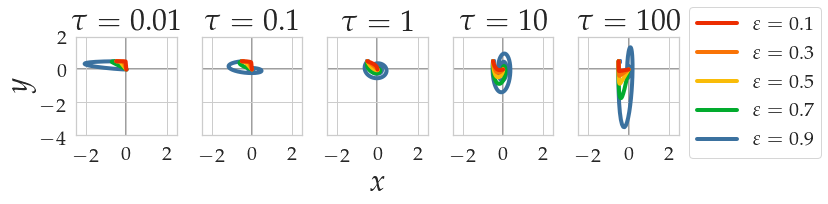

In [17]:

bddy1=2; bddy2=4#3.5
bddx=2.5
cols=['xkcd:tomato red', 'xkcd:orange','xkcd:golden rod','xkcd:kelly green','xkcd:muted blue']
fig, ax = plt.subplots(1, len(tau_vals), figsize=(7*len(tau_vals)/3, 6/2), sharex=True, sharey=True)
for tau_num,tau in enumerate(tau_vals):
    for enum,eps in enumerate(eps_vals):

        ax[tau_num].plot(vals[(eps,tau)][0,0],vals[(eps,tau)][0,1], color='b',marker='o', markerfacecolor='xkcd:grey', markersize=4)
        ax[tau_num].plot(vals[(eps,tau)][:,0],vals[(eps,tau)][:,1], color=cols[enum],label=r'$\varepsilon = '+str(eps)+'$', linewidth=4, zorder=10-enum)
    ax[tau_num].set_xlim([-bddx, bddx])
    ax[tau_num].set_ylim([-bddy2, bddy1])
    ax[tau_num].set(xticks=[-2,0,2])
    ax[tau_num].set(yticks=[-4,-2,0,2])
    ax[tau_num].tick_params(labelsize=ls)
    if tau<.1:ax[tau_num].set_title(r'$\tau=%.2f$'%tau, fontsize=fs)
    elif tau<1:ax[tau_num].set_title(r'$\tau=%.1f$'%tau, fontsize=fs)
    else: ax[tau_num].set_title(r'$\tau=%d$'%tau, fontsize=fs)
    ax[tau_num].axvline(x=0, color='gray', zorder=-100)
    ax[tau_num].axhline(y=0, color='gray', zorder=-100)
ax[0].set_ylabel(r'$y$', fontsize=fs)    
ax[2].set_xlabel(r'$x$', fontsize=fs)    
#fig.text(0.5, -0.1, '$x$', ha='center', fontsize=fs)
#fig.text(-0.015, 0.5, '$y$', va='center', rotation='vertical', fontsize=fs)
plt.tight_layout()
plt.legend(loc='best',fontsize=20, bbox_to_anchor=(1,1.4))
plt.tight_layout()
plt.savefig('torus_figs/traj.pdf', bbox_to_inches='tight')

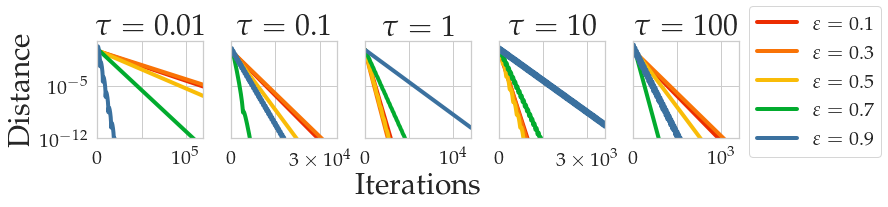

In [18]:
eps=0.1; tau=1
bdd=1.2
cols=['xkcd:tomato red', 'xkcd:orange','xkcd:golden rod','xkcd:kelly green','xkcd:muted blue']
fig, ax = plt.subplots(1, len(tau_vals), figsize=(7*len(tau_vals)/2.8, 6/2), sharey=True)

errors={}
for tau in tau_vals:
    for eps in eps_vals:
        errs=[]
        for v in vals[(eps,tau)]:
            errs.append(la.norm(v))
        errors[(eps,tau)]=np.asarray(errs)
for tau_num,tau in enumerate(tau_vals):
    for enum,eps in enumerate(eps_vals):
        ax[tau_num].plot(errors[(eps,tau)], label=r'$\varepsilon = '+str(eps)+'$', color=cols[enum],linewidth=4)

    ax[tau_num].tick_params(labelsize=ls)
    ax[tau_num].set(ylim=[1e-16, 1e1])
    if tau<.1:ax[tau_num].set_title(r'$\tau=%.2f$'%tau, fontsize=fs)
    elif tau<1:ax[tau_num].set_title(r'$\tau=%.1f$'%tau, fontsize=fs)
    else: ax[tau_num].set_title(r'$\tau=%d$'%tau, fontsize=fs)
    
# DELETE ALL THIS IF YOU WANT TO AUTO SET THE AXIS
ax[0].set(ylim=[1e-12,1e1],yticks=[1e-10, 1e-5, 1])
ax[0].set(xlim=[0,100000*1.2],xticks=[0,50000,100000],xticklabels=['0','',r'$10^5$'])
ax[1].set(xlim=[0,30000*1.2],xticks=[0,15000,30000],xticklabels=['0','',r'$3\times 10^4$'])
ax[2].set(xlim=[0,10000*1.2],xticks=[0,5000, 10000], xticklabels=['0','',r'$10^4$'])
ax[3].set(xlim=[0,3000*1.2],xticks=[0,1500,3000], xticklabels=['0','',r'$3\times 10^3$'])
ax[4].set(xlim=[0,1000*1.2],xticks=[0,500,1000], xticklabels=['0','',r'$10^3$'])
######

ax[2].set_xlabel('Iterations', ha='center', fontsize=fs)
ax[3].set_xlabel('', ha='center', fontsize=fs)
ax[0].set_ylabel('Distance', fontsize=fs)
#fig.text(-0.05, 0.5, 'log scale error', va='center', rotation='vertical', fontsize=fs)
plt.yscale("log")
plt.tight_layout()
plt.legend(loc='best',fontsize=20, bbox_to_anchor=(1,-.3))
plt.tight_layout()
plt.savefig('torus_figs/convergence.pdf', bbox_to_inches='tight')

In [9]:
tau=10000
la.eigvals(np.vstack(((1-eps)*P1+eps*H1,tau*((1-eps)*P2+eps*H2))))

array([ 33.83463193, 966.46536807])

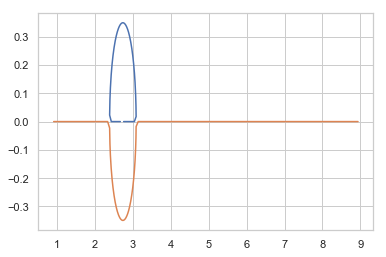

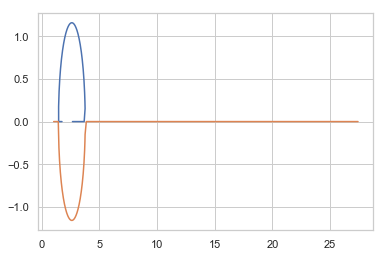

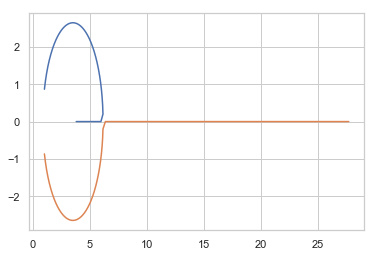

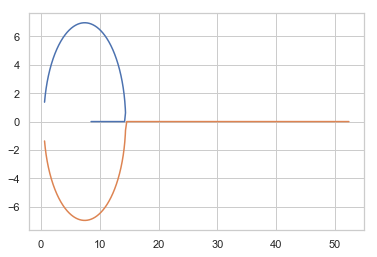

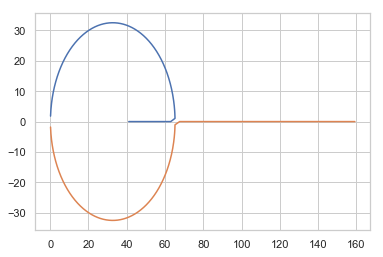

In [10]:
etaus=[10,40,60,200,2000]
for eps,etau in zip(eps_vals,etaus):

    taus=np.linspace(1,etau,1000)
    es=[]
    for tau in taus:
        J=np.vstack(((1-eps)*P1+eps*H1,tau*((1-eps)*P2+eps*H2)))
        es.append(la.eigvals(J))
    evals=np.asarray(es)
    plt.figure()
    plt.plot(np.real(evals), np.imag(evals))